# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state

- Initial State: The empty board
- Actions: dropping a colored disc into a column, which lands in the next available spot vertically in that column
- Transition Model: the new board containing the result of the action the player took
- Goal State: a board that contains 4 same-colored discs in a row, either horizantally, vertically, or diagonally

How big is the state space? Give an estimate and explain it.

- The state space is given by calculating a permutation using the number of states (3: empty, player 1 disc, and player 2 disc) and the number of spots on the board. So with mxn being the number of spots on the board, the size of the state space is 3^mxn

How big is the game tree that minimax search will go through? Give an estimate and explain it.

- The height of the tree is at most the depth of what is given for the algorithm to use. In my case I used 5, the max number of nodes it will have will be 2^(depth) - 1

## Task 2: Game Environment and Random Agent [2 point]

Use a numpy character array as the board.

In [ ]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player whose next move it is and who the agent should play.

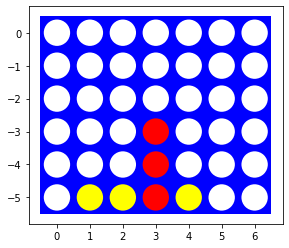

In [ ]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* The transition model (result).
* The utility function.
* Check for terminal states.
* A check for available actions.

Make sure that all these functions work with boards of different sizes.

Implement an agent that plays randomly and let two random agents play against each other 1000 times. How often does each player win? Is the result expected? 

In [229]:
def result(player, action, board):
    x = action[0]
    y = action[1]
    board[x][y] = player
    return board

def utility(player, scores):
    if player == 1:
        scores[0] += 1
    elif player == -1:
        scores[1] += 1
    else:
        scores[2] += 1 #keep track of draws in index 2
    return scores
        
def check_horizontal(x, y, board):
    player = curr_space = board[x][y]
    cnt = 1
    while x > 0 and curr_space == player: # move to left most position while checking
        x -= 1
        curr_space = board[x][y]
        cnt += 1
    if cnt > 4:
        return True
    else: # check right
        x += cnt - 1
        curr_space = board[x][y]
        cnt = 1
        while x < len(board) - 1 and cnt <= 4 and curr_space == player:
            x += 1
            curr_space = board[x][y]
            cnt += 1
        if cnt > 4:
            return True
        
    return False

def check_vertical(x, y, board):
    player = curr_space = board[x][y]
    cnt = 1
    while y > 0 and curr_space == player: # move to up most position while checking
        y -= 1
        curr_space = board[x][y]
        cnt += 1
    if cnt > 4:
        return True
    else: # check down
        y += cnt - 1
        curr_space = board[x][y]
        cnt = 1
        while y < len(board[x]) - 1 and cnt <= 4 and curr_space == player:
            y += 1
            curr_space = board[x][y]
            cnt += 1
        if cnt > 4:
            return True
        
    return False

def check_diagonal(x, y, board):
    num_x = len(board)
    num_y = len(board[x])
    player = curr_space = board[x][y]
    cnt = 1
    while x > 0 and y > 0 and curr_space == player: # move to up most position while checking
        x -= 1
        y -= 1
        curr_space = board[x][y]
        cnt += 1
    if cnt > 4:
        return True
    else: # check down
        x += cnt - 1
        y += cnt - 1
        curr_space = board[x][y]
        cnt = 1
        while x < num_x - 1 and y < num_y - 1 and cnt <= 4 and curr_space == player:
            x += 1
            y += 1
            curr_space = board[x][y]
            cnt += 1
        if cnt > 4:
            return True
        
    return False
        
def terminal_check(pos, board):
    x = pos[0]
    y = pos[1]
    curr_space = board[x][y]
    if curr_space != 0:
        if check_horizontal(x, y, board) or check_vertical(x, y, board) or check_diagonal(x, y, board):
            return True
    return False

def available_actions(board):
    available = []
    
    for x in range(len(board)):
        for y in range(len(board[x]) - 1, -1, -1):
            curr_space = board[x][y]
            if curr_space == 0:
                pos = (x, y)
                available.append(pos)
                break
                
    return available

def agent(board, player):
    actions = available_actions(board)
    if len(actions) == 0:
        return None
    index = np.random.choice(len(actions))
    return actions[index]

In [197]:
def play_game(n = 1000):
    player_scores = [0, 0, 0]
    for i in range(n):
        curr_player = 1
        board = empty_board()
        is_terminal = False
        while not is_terminal:
            action = agent(board, curr_player)
            
            if action is None: 
                curr_player = 0
                break
                
            board = result(curr_player, action, board)
            is_terminal = terminal_check(action, board)
            curr_player *= -1 # toggle player
        player_scores = utility(curr_player, player_scores)
        
    print("Player 1 Score: " + str(player_scores[0]))
    print("Player 2 Score: " + str(player_scores[1]))
    print("Draws: " + str(player_scores[2]))

In [198]:
play_game()

Player 1 Score: 504
Player 2 Score: 493
Draws: 3


- Each player wins nearly close to half the time, which is expected as the location in which they drop the column is being decided in a uniform random form (equal chance for all choices)

## Task 3: Minimax Search with Alpha-Beta Pruning [4 points]

### Implement the search starting from a given board and specifying the player.



__Note:__ The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [236]:
def minimax(curr_loc, player, board):
    result = max_val(5, -1000, 1000, curr_loc, player, board)
    return result[1]

def min_val(depth, alpha, beta, loc, player, board):
    is_terminal = terminal_check(loc, board)
    if depth == 0 or is_terminal:
        if is_terminal:
            print("Win Complete")
            return 0, (0,0)
        return 1, loc

    min_val = 1000
    min_action = (0, 0)
    actions = available_actions(board)
    for a in actions:
        val = max_val(depth - 1, alpha, beta, a, toggle(player), board)

        if val[0] < min_val:
            min_val = val[0]
            min_action = val[1]
            beta = min(beta, min_val)
        if beta <= alpha:
            break

    return (min_val, min_action)

def max_val(depth, alpha, beta, loc, player, board):
    is_terminal = terminal_check(loc, board)
    if depth == 0 or is_terminal:
        if is_terminal:
            print("Win Complete")
            return 0, (0,0)
        return 1, loc

    max_val = -1
    max_action = (0, 0)
    actions = available_actions(board)
    for a in actions:
        val = min_val(depth - 1, alpha, beta, a, player, board)

        if val[0] > max_val:
            max_val = val[0]
            max_action = val[1]
            alpha = max(alpha, max_val)
        if beta <= alpha:
            break

    return (max_val, max_action)

def toggle(player):
    return player * -1

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [231]:
board = empty_board()
board[0][6] = board[1][6] = board[2][6] = 1
action = minimax((0, 6) ,1, board)
print(board)
print(action)

[[0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
(0, 5)


In [232]:
board = empty_board()
board[0][6] = board[0][5] = board[0][4] = 1
board[1][6] = board[1][5] = board[1][4] = -1
action = minimax((0, 6) ,1, board)
print(board)
print(action)

[[ 0  0  0  0  1  1  1]
 [ 0  0  0  0 -1 -1 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
(0, 3)


In [233]:
board = empty_board()
board[0][6] = board[0][5] = board[0][4] = board[2][6] = 1
board[1][6] = board[1][5] = board[1][4] = -1
action = minimax((0, 6) ,1, board)
print(board)
print(action)

[[ 0  0  0  0  1  1  1]
 [ 0  0  0  0 -1 -1 -1]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
(0, 3)


In [234]:
board = empty_board()
board[0][6] = board[0][5] = board[0][4] = board[3][6] = 1
board[1][6] = board[1][5] = board[1][4] = board[2][6] = -1
action = minimax((0, 6) ,1, board)
print(board)
print(action)

[[ 0  0  0  0  1  1  1]
 [ 0  0  0  0 -1 -1 -1]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
(0, 3)


In [237]:
board = empty_board()
board[0][6] = board[0][5] = board[0][4] = board[0][3] = 1
board[1][6] = board[1][5] = board[1][4] = board[2][6] = -1
action = minimax((0, 6) ,1, board)
print(board)
print(action)

Win Complete
[[ 0  0  0  1  1  1  1]
 [ 0  0  0  0 -1 -1 -1]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
(0, 0)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

# Small Board

In [246]:
board = empty_board((4,4))
action = minimax((0, 0) ,1, board)
print(board)
print(action)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
(0, 3)


Time: 0.2s

In [248]:
board = empty_board((4, 4))
board[0][3] = board[0][2] = board[0][1] = 1
board[1][3] = board[1][2] = board[1][1] = board[2][3] = -1
action = minimax((0, 0) ,1, board)
print(board)
print(action)

[[ 0  1  1  1]
 [ 0 -1 -1 -1]
 [ 0  0  0 -1]
 [ 0  0  0  0]]
(0, 0)


Time: 0.3s

# Medium Board

In [249]:
board = empty_board((5,5))
action = minimax((0, 0) ,1, board)
print(board)
print(action)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0, 4)


Time: 0.3s

In [253]:
board = empty_board((5,5))
board[0][4] = board[0][3] = board[0][2] = board[1][2] = 1
board[1][4] = board[1][3] = board[1][2] = -1
action = minimax((0, 0) ,1, board)
print(board)
print(action)

[[ 0  0  1  1  1]
 [ 0  0 -1 -1 -1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
(0, 1)


Time: 0.3s

# Full Board

In [257]:
board = empty_board()
action = minimax((0, 0) ,1, board)
print(board)
print(action)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
(0, 6)


Time: 0.3s

In [258]:
board = empty_board()
board[0][6] = board[0][5] = board[0][4] = board[1][4] = 1
board[1][6] = board[1][5] = board[1][4] = -1
action = minimax((0, 0) ,1, board)
print(board)
print(action)

[[ 0  0  0  0  1  1  1]
 [ 0  0  0  0 -1 -1 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
(0, 3)


Time: 0.2s

Discussion: Creating a board and making move takes the same amount of time than just making creating the board. The results above seem to show that the time to make a move does not affect the total runtime.

### Move ordering

Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [ ]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [ ]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [+ 1 bonus point]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [ ]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move is? You can use Pure Monte Carlo Search or any algorithms 
that you have implemented above.

In [ ]:
# Your code/ answer goes here.